# Quantum Kernel Training algorithm

The structure of the quantum embedding circuit plays a decisive role in the QSVM algorithm.
Numerous quantum embedding kernel ansätze have been proposed. Testing all of them for a new dataset is unfeasible.
Therefore, following the method known in the classical kernel SVM such as the *kernel metrics learning* or the *kernel target alignment*, the quantum circuit structure could be trained to increase the separability of the data in the feature space.
For this, the encoding circuit is complemented with the variational part, i. e., with additional gates that depend on variable parameters.
The variational parameters will be obtained as a result of the optimizational procedure to minimize a specially selected loss function.
This approach combines the ideas of the quantum kernel with the variational quantum circuit approaches.

[1] Lloyd, S.; Schuld, M.; Ijaz, A.; Izaac, J.; Killoran, N. Quantum Embeddings for Machine Learning. arXiv:2001.03622 (2020)

[2] Hubregtsen, T.; Wierichs, D.; Gil-Fuster, E.; Derks, P.-J. H. S.; Faehrmann, P. K.; Meyer, J. J. Training Quantum Embedding Kernels on Near-Term Quantum Computers. arXiv:2105.02276 (2021)

[3] (1) Glick, J. R.; Gujarati, T. P.; Corcoles, A. D.; Kim, Y.; Kandala, A.; Gambetta, J. M.; Temme, K. Covariant Quantum Kernels for Data with Group Structure. arxiv:2105.03406 (2021)

In [1]:
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics

from qksvm.QuantumFeatureMap import QuantumFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.utils import algorithm_globals

from qksvm.LossFunctions import SVCLoss
from qksvm.QuantumKernelTraining import QuantumKernelTraining
from qksvm.QuantumKernelTraining import TerminationChecker
from qiskit.algorithms.optimizers import SPSA

from common import generate_moons_dataset
from common import visualize_decision_boundaries
from common import print_scores

seed = 12345

# Dataset

The [moons dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) is chosen for the demonstration purposes.
This dataset has non-trivial and non-linear decision boundaries such that no separating hyperplane could be found to perfectly split 2 data classes.

Following the standard machine learning (ML) practice, we generate 2 independent datasets. The first dataset (`X_train`=($x_1$, $x_2$) - the 2d cartesian coordinates, and `y_train`={0, 1} - the datapoint labels) is used for training the chosen model and optimizing the model hyperparameters.
The second dataset `(X_test, y_test)` serves to crosscheck the accuracy of the model on previously unseen datapoints (thus testing the model generalization performance).

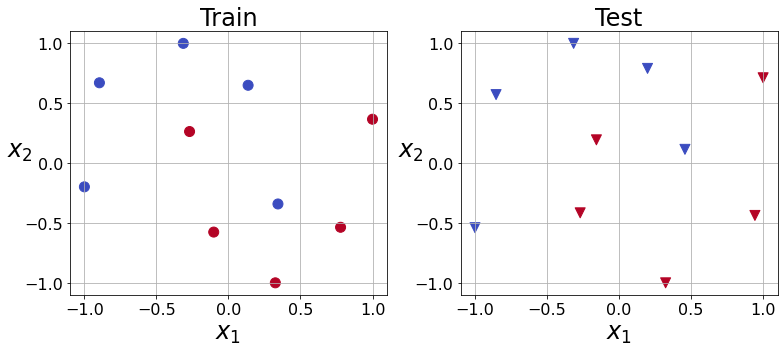

(10, 2)
(10, 2)


In [2]:
X_train, y_train, X_test, y_test = generate_moons_dataset()
print(X_train.shape)
print(X_test.shape)

# Quantum Kernel Training embedding variational ansatz

The quantum feature map generator considered earlier in the QKE tutorial can be used to generate the variational circuits.
As we have already used it in the Quantum Kernel Estimate SVC tutorial, the `QuantumFeatureMap` generator treats the gates given in the upper case as the encoding gates (i. e., the gates that depend parametrically on the input dataset points). All the parametric gates given in the lower case will be considered by the generator the variational gates.
The circuit generator also allows us to include the scaling prefactor $\alpha$ into the list of the variational parameters. If `scale=True`, the $\theta[0]$ is set as a prefactor, otherwise the value of $\alpha$ should be provided by the user.
The total number of the variational parameters could be controlled by increasing the number of the variational gates, the number of qubits, and the number layers (circuit repetitions). In this way, the optimal quantum embedding ansatz can be found that leads to the best performing classification model.

In [3]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 2

fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['rx', 'cz', 'RY'],
    entanglement='linear',
    scale=True,
)
print(fm.draw(plot_barriers=False, fold=150))

     ┌──────────┐     ┌───────────────┐ ┌──────────┐     ┌───────────────┐ 
q_0: ┤ Rx(θ[1]) ├──■──┤ Ry(x[0]*θ[0]) ├─┤ Rx(θ[3]) ├──■──┤ Ry(x[0]*θ[0]) ├─
     ├──────────┤  │  ├───────────────┤ ├──────────┤  │  ├───────────────┤ 
q_1: ┤ Rx(θ[2]) ├──■──┤ Ry(x[1]*θ[0]) ├─┤ Rx(θ[4]) ├──■──┤ Ry(x[1]*θ[0]) ├─
     └──────────┘     └───────────────┘ └──────────┘     └───────────────┘ 


For the purpose of the tutorial, we choose the Qiskit statevector backend that simulates an ideal quantum device.

In [4]:
algorithm_globals.random_seed = seed
backend = QuantumInstance(
    AerSimulator(
        method='statevector',
        max_parallel_threads=8,
    ),
    seed_simulator=seed, seed_transpiler=seed,
)

To initialize the optimization procedure one should choose a loss function.
By setting `SVCLoss`, the optimization algoritm will search for the parameters $\theta$ that maximize the margin between the positive and negative class training points embedded into the quantum Hilbert space.

The dependence of the loss function on the scaling parameter $\theta[0]$ could be visualized. 

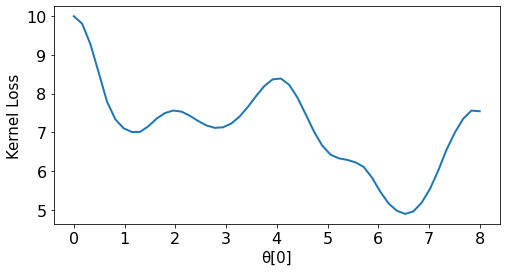

In [5]:
loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)
loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)

As we can see, the loss function landscape consists of many closely lying minima therefore a special care should be taken regarding the choice of an efficient optimization technique.
Qiskit provides implementations and wrappers for a majority of the [optimization algorithms](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html). 
Below we set the Simultaneous Perturbation Stochastic Approximation (SPSA) optimizer which is widely used in the quantum variational algorithms.

In [6]:
optimizer = SPSA(
    maxiter=100,
    learning_rate=None,
    perturbation=None,
    termination_checker=None,
    perturbation_dims=None,
)

By setting the loss function and the optimizer we are ready to compute the optimized quantum kernel.
As in the QKE algorithm, the kernel will be used for training the SVC.

Loss function value:  3.325266781606861
Optimal parameters: [2.34885347 3.75660594 2.06540093 2.49323603 5.23466394]


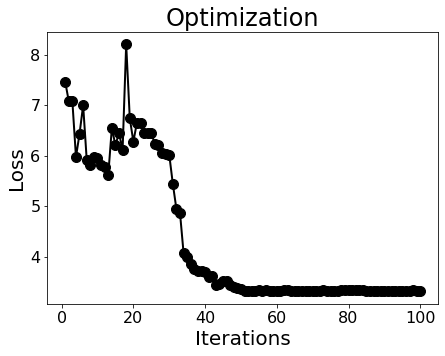


Prediction Scores:

		Train	Test
Accuracy:	1.00	1.00
 ROC_AUC:	1.00	1.00



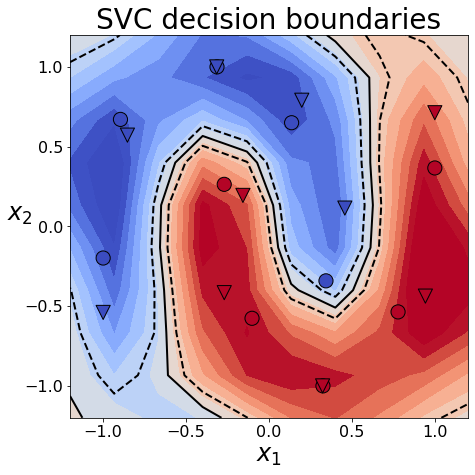

In [7]:
np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 1.0

qkt = QuantumKernelTraining(
    fm,
    X_train, y_train,
    init_params,
    loss=loss,
    optimizer=optimizer,
    backend=backend,
    seed=seed, 
    plot=True,
)

# Model training
clf = SVC(kernel=qkt.quantum_kernel.evaluate, random_state=seed)

clf.fit(X_train, y_train)
print_scores(clf, X_train, y_train, X_test, y_test)
visualize_decision_boundaries(clf, X_train, y_train, X_test, y_test)

As we can see, it takes around 50 optimization iterations to minimize the loss function.
The quantum kernel computed with the optimized variational embedding ansatz leads to the maximum classification accuracy and (visually) expected decision boundaries.